In [2]:
# %% [markdown]
# # Sentiment Analysis with RoBERTa Transformer
# Using Twitter-trained RoBERTa model for EA Forum Posts

# %%
# Install required packages (run once)
# !pip install pandas transformers torch accelerate matplotlib seaborn wordcloud tqdm

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torch
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1
print(f"Using: {'GPU 🚀' if device == 0 else 'CPU'}")

# %%
# Load the data
df = pd.read_csv('ea_forum_posts.csv')
print(f"Loaded {len(df)} posts")

# Combine title and body for better context
df['full_text'] = df['title'].fillna('') + '. ' + df['body_preview'].fillna('')
df['full_text'] = df['full_text'].str.strip()

df.head()

# %% [markdown]
# ## RoBERTa Model
# Using Cardiff NLP's RoBERTa trained on Twitter data - excellent for informal text and forums

# %%
# Initialize RoBERTa sentiment analysis pipeline
print("Loading RoBERTa model (this may take a minute)...")

sentiment_roberta = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    device=device,
    truncation=True,
    max_length=512
)

print("✅ RoBERTa model loaded!")

# %%
# Function to safely analyze sentiment with error handling
def analyze_sentiment(text, analyzer):
    """Analyze sentiment with error handling for long/problematic texts"""
    if pd.isna(text) or not text.strip():
        return {'label': 'neutral', 'score': 0.0}
    
    try:
        # Truncate very long texts
        text = str(text)[:1500]
        result = analyzer(text)[0]
        return result
    except Exception as e:
        print(f"Error analyzing text: {e}")
        return {'label': 'neutral', 'score': 0.0}

# %%
# Analyze with RoBERTa
print("Analyzing sentiment with RoBERTa...")
tqdm.pandas(desc="RoBERTa Analysis")

roberta_results = df['full_text'].progress_apply(
    lambda x: analyze_sentiment(x, sentiment_roberta)
)

df['roberta_label'] = roberta_results.apply(lambda x: x['label'])
df['roberta_score'] = roberta_results.apply(lambda x: x['score'])

# Map labels to standardized format
label_map_roberta = {
    'positive': 'Positive',
    'negative': 'Negative', 
    'neutral': 'Neutral'
}
df['sentiment'] = df['roberta_label'].map(label_map_roberta)
df['confidence'] = df['roberta_score']

# Create compound score (-1 to 1)
def calculate_compound(row):
    label = row['sentiment']
    score = row['confidence']
    if label == 'Positive':
        return score
    elif label == 'Negative':
        return -score
    return 0

df['compound_score'] = df.apply(calculate_compound, axis=1)

# %%
# Display Results Summary
print("=" * 60)
print("ROBERTA SENTIMENT ANALYSIS RESULTS")
print("=" * 60)

print(f"\n📊 Total Posts Analyzed: {len(df)}")

print("\n" + "-" * 40)
print("Sentiment Distribution:")
print("-" * 40)
print(df['sentiment'].value_counts())

print(f"\nPercentages:")
print(df['sentiment'].value_counts(normalize=True).mul(100).round(1))

print(f"\nAverage Compound Score: {df['compound_score'].mean():.3f}")
print(f"Average Confidence: {df['confidence'].mean():.3f}")




/Users/porkr/projects/ea_scraper/fc2026/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Using: CPU
Loaded 1551 posts
Loading RoBERTa model (this may take a minute)...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ RoBERTa model loaded!
Analyzing sentiment with RoBERTa...


RoBERTa Analysis:   0%|          | 0/1551 [00:00<?, ?it/s]

ROBERTA SENTIMENT ANALYSIS RESULTS

📊 Total Posts Analyzed: 1551

----------------------------------------
Sentiment Distribution:
----------------------------------------
sentiment
Negative    1221
Neutral      280
Positive      50
Name: count, dtype: int64

Percentages:
sentiment
Negative    78.7
Neutral     18.1
Positive     3.2
Name: proportion, dtype: float64

Average Compound Score: -0.595
Average Confidence: 0.765


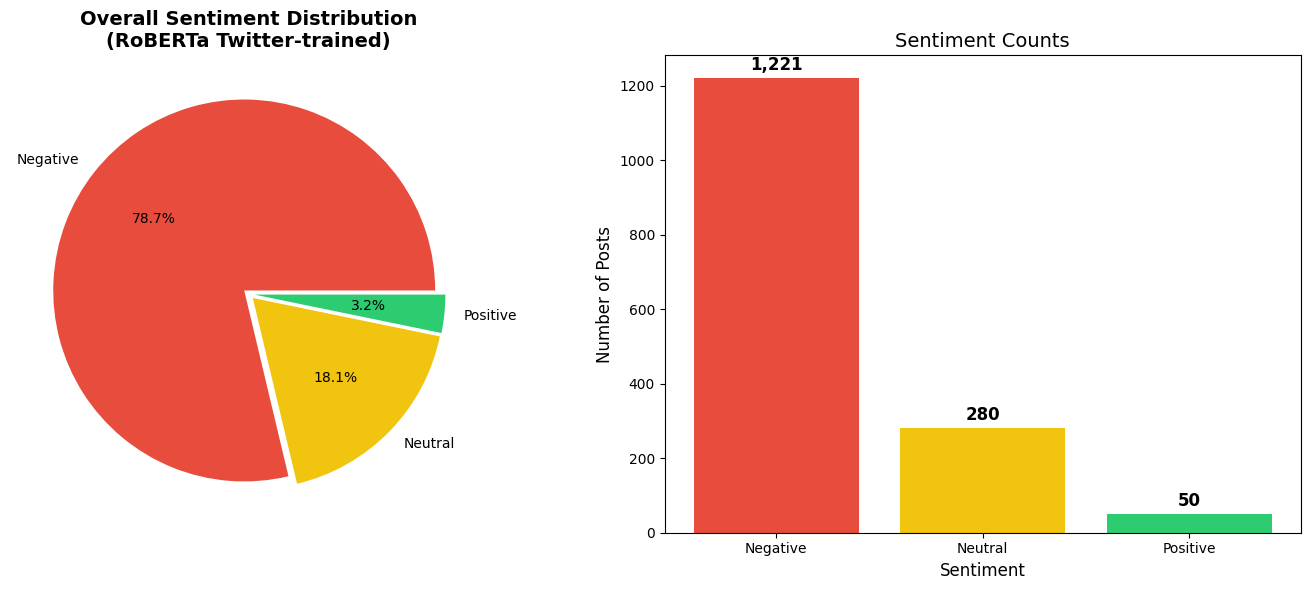

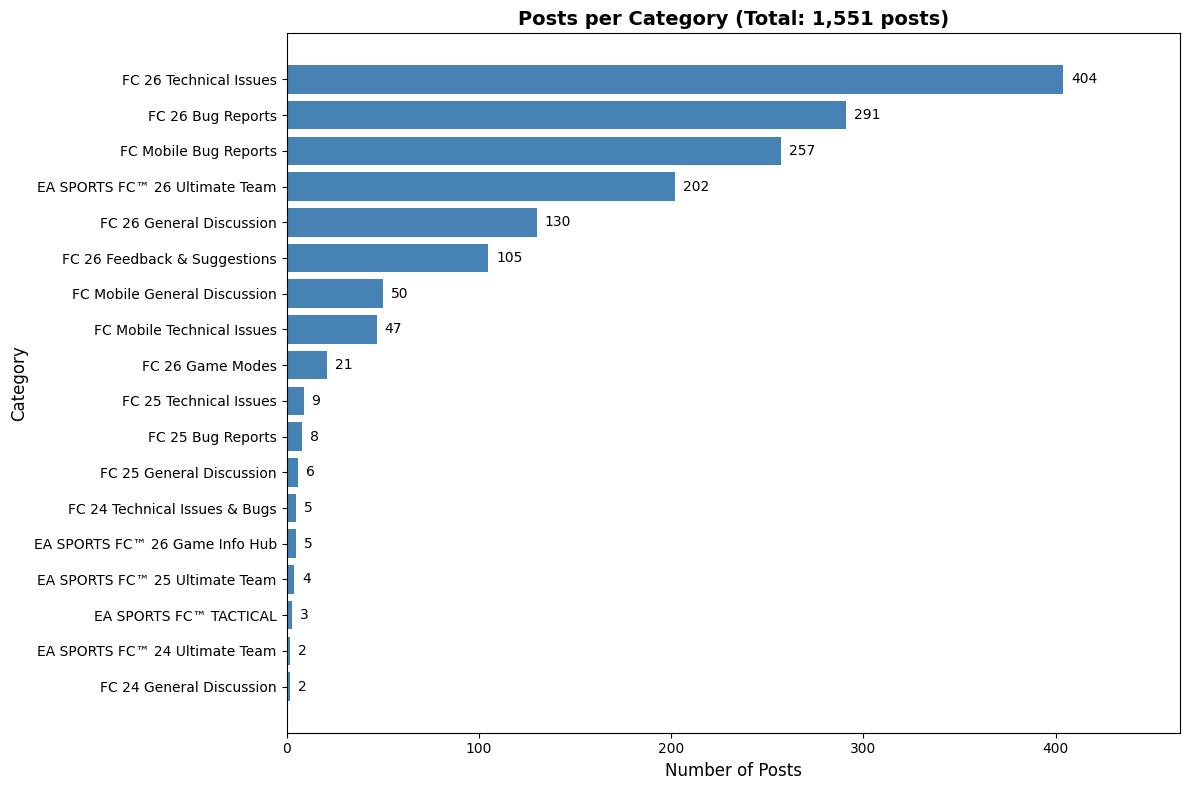


----------------------------------------
📊 POSTS PER CATEGORY:
----------------------------------------
  FC 26 Technical Issues: 404 posts (26.0%)
  FC 26 Bug Reports: 291 posts (18.8%)
  FC Mobile Bug Reports: 257 posts (16.6%)
  EA SPORTS FC™ 26 Ultimate Team: 202 posts (13.0%)
  FC 26 General Discussion: 130 posts (8.4%)
  FC 26 Feedback & Suggestions: 105 posts (6.8%)
  FC Mobile General Discussion: 50 posts (3.2%)
  FC Mobile Technical Issues: 47 posts (3.0%)
  FC 26 Game Modes: 21 posts (1.4%)
  FC 25 Technical Issues: 9 posts (0.6%)
  FC 25 Bug Reports: 8 posts (0.5%)
  FC 25 General Discussion: 6 posts (0.4%)
  FC 24 Technical Issues & Bugs: 5 posts (0.3%)
  EA SPORTS FC™ 26 Game Info Hub: 5 posts (0.3%)
  EA SPORTS FC™ 25 Ultimate Team: 4 posts (0.3%)
  EA SPORTS FC™ TACTICAL: 3 posts (0.2%)
  EA SPORTS FC™ 24 Ultimate Team: 2 posts (0.1%)
  FC 24 General Discussion: 2 posts (0.1%)


<Figure size 1400x800 with 0 Axes>

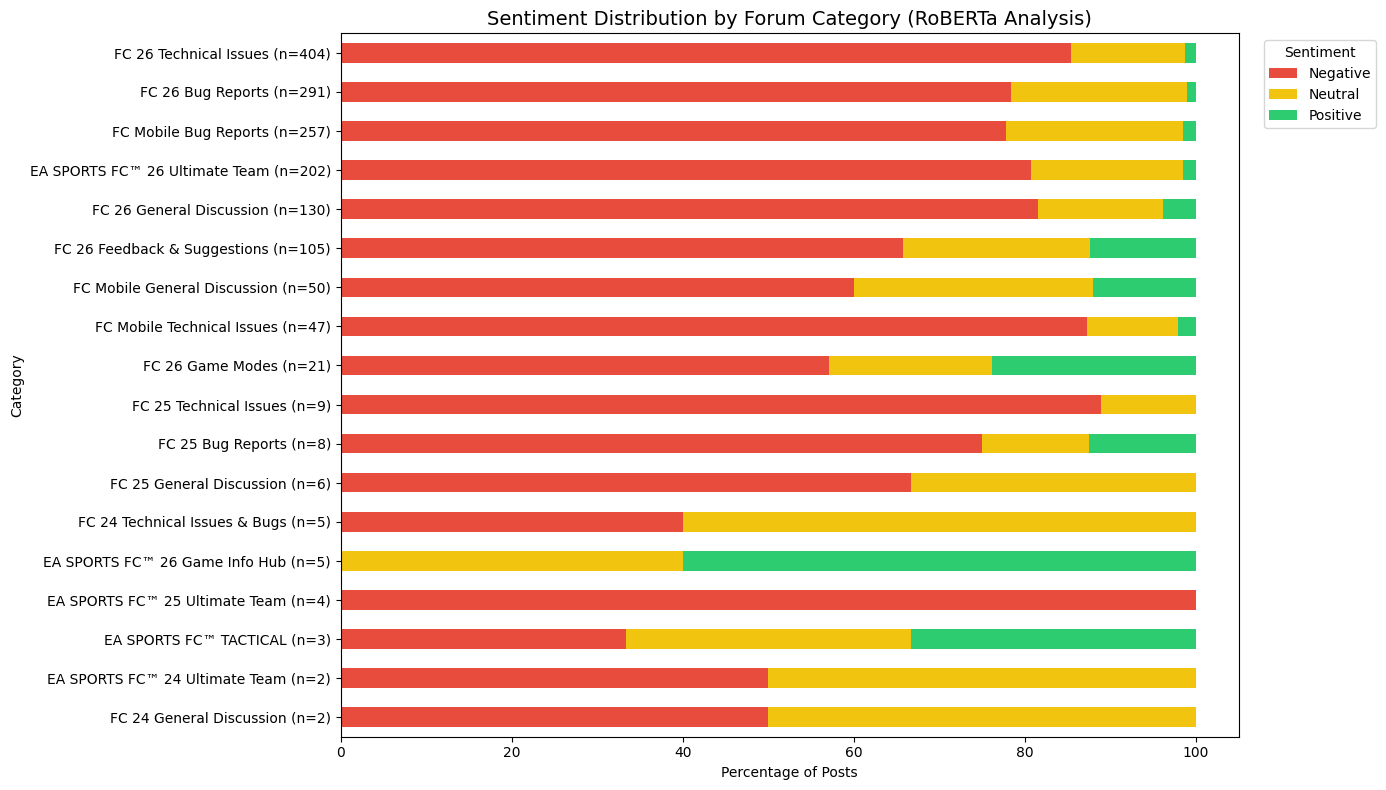

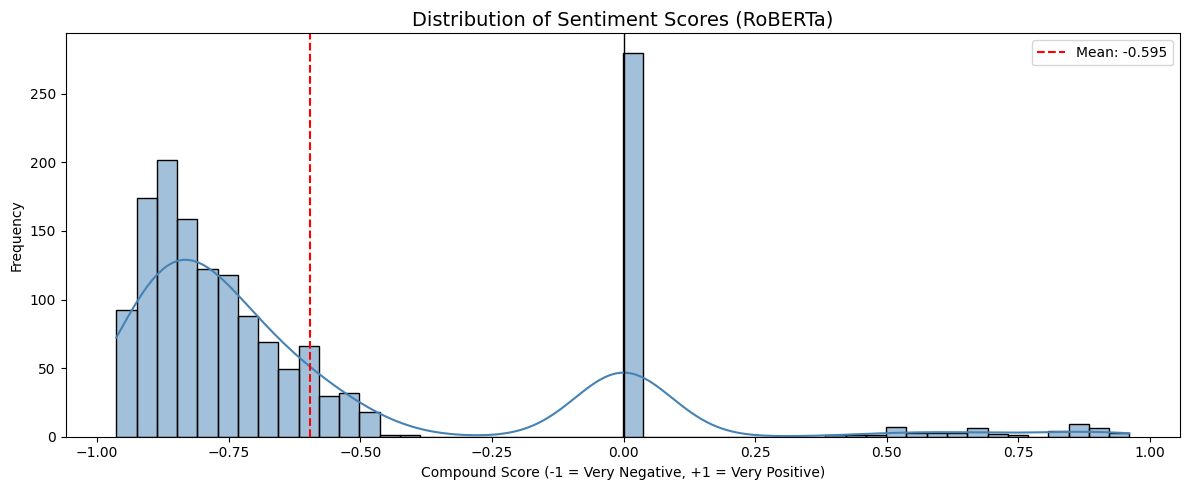

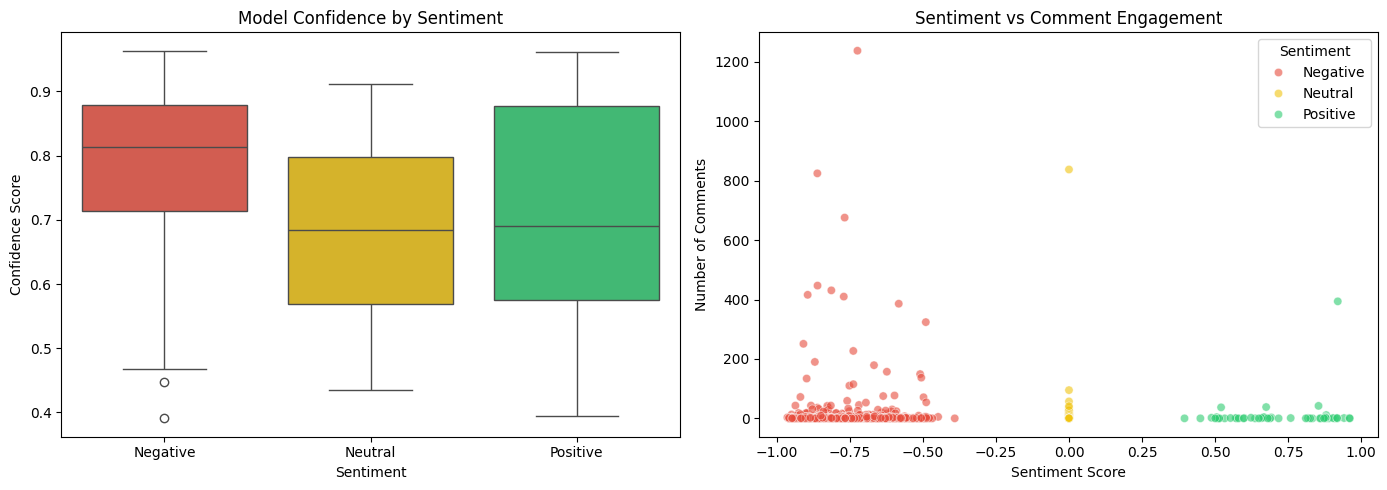

✅ Results exported to 'ea_forum_sentiment_roberta.csv'

📊 FINAL SENTIMENT ANALYSIS REPORT

📈 OVERVIEW
────────────────────────────────────────
Total Posts Analyzed: 1,551
Model: RoBERTa (Twitter-trained)
Average Sentiment Score: -0.595
Average Model Confidence: 0.765

📊 SENTIMENT BREAKDOWN
────────────────────────────────────────
🟢 Positive: 50 (3.2%)
🟡 Neutral:  280 (18.1%)
🔴 Negative: 1,221 (78.7%)

🎯 KEY INSIGHTS
────────────────────────────────────────
• Overall forum sentiment: NEGATIVE 😠
• Most discussed issues appear in negative posts
• High-engagement posts tend to be more negative

📁 FILES GENERATED
────────────────────────────────────────
• ea_forum_sentiment_roberta.csv (full results)
• sentiment_distribution.png
• posts_per_category.png
• sentiment_by_category.png
• compound_score_distribution.png
• confidence_and_engagement.png
• correlation_matrix.png



In [4]:
# %%
# Visualization 1: Overall Sentiment Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = {'Positive': '#2ecc71', 'Neutral': '#f1c40f', 'Negative': '#e74c3c'}

# Pie chart
ax1 = axes[0]
sentiment_counts = df['sentiment'].value_counts()
ax1.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
        colors=[colors.get(l, '#95a5a6') for l in sentiment_counts.index],
        explode=[0.03] * len(sentiment_counts))
ax1.set_title('Overall Sentiment Distribution\n(RoBERTa Twitter-trained)', fontsize=14, fontweight='bold')

# Bar chart with counts
ax2 = axes[1]
bars = ax2.bar(sentiment_counts.index, sentiment_counts.values,
               color=[colors.get(l, '#95a5a6') for l in sentiment_counts.index])
ax2.set_xlabel('Sentiment', fontsize=12)
ax2.set_ylabel('Number of Posts', fontsize=12)
ax2.set_title('Sentiment Counts', fontsize=14)

# Add count labels on bars
for bar, count in zip(bars, sentiment_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sentiment_counts.values)*0.01,
             f'{count:,}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('sentiment_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# %%
# Visualization 2a: Category Post Counts
if 'category' in df.columns:
    plt.figure(figsize=(12, 8))
    
    # Get category counts and sort descending (already default for value_counts)
    category_counts = df['category'].value_counts()
    
    # Reverse order so highest count appears at the top of horizontal bar chart
    category_counts = category_counts.iloc[::-1]
    
    # Create horizontal bar chart
    bars = plt.barh(range(len(category_counts)), category_counts.values, color='steelblue')
    plt.yticks(range(len(category_counts)), category_counts.index)
    
    # Add count labels on the bars
    for i, (count, bar) in enumerate(zip(category_counts.values, bars)):
        plt.text(count + max(category_counts.values) * 0.01, i, f'{count:,}', 
                 va='center', fontsize=10)
    
    plt.xlabel('Number of Posts', fontsize=12)
    plt.ylabel('Category', fontsize=12)
    plt.title(f'Posts per Category (Total: {len(df):,} posts)', fontsize=14, fontweight='bold')
    plt.xlim(0, max(category_counts.values) * 1.15)
    plt.tight_layout()
    plt.savefig('posts_per_category.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary (use original descending order for readability)
    category_counts_print = df['category'].value_counts()
    print("\n" + "-" * 40)
    print("📊 POSTS PER CATEGORY:")
    print("-" * 40)
    for cat, count in category_counts_print.items():
        pct = count / len(df) * 100
        print(f"  {cat}: {count:,} posts ({pct:.1f}%)")

# %%
# Visualization 2b: Sentiment by Category
if 'category' in df.columns:
    plt.figure(figsize=(14, 8))
    
    # Get category counts for labels (descending order by count)
    category_counts = df['category'].value_counts()
    
    # Calculate sentiment percentages by category
    category_sentiment = pd.crosstab(
        df['category'], 
        df['sentiment'], 
        normalize='index'
    ) * 100
    
    # Sort by category count (descending) - reindex to match category_counts order
    # Then reverse so highest count appears at top of horizontal bar chart
    category_sentiment = category_sentiment.reindex(category_counts.index)
    category_sentiment = category_sentiment.iloc[::-1]
    
    # Create labels with counts
    new_labels = [f"{cat} (n={category_counts[cat]:,})" for cat in category_sentiment.index]
    category_sentiment.index = new_labels
    
    # Plot
    category_sentiment.plot(
        kind='barh',
        stacked=True,
        color=[colors.get(c, '#95a5a6') for c in category_sentiment.columns],
        figsize=(14, 8)
    )
    
    plt.title('Sentiment Distribution by Forum Category (RoBERTa Analysis)', fontsize=14)
    plt.xlabel('Percentage of Posts')
    plt.ylabel('Category')
    plt.legend(title='Sentiment', bbox_to_anchor=(1.02, 1))
    plt.tight_layout()
    plt.savefig('sentiment_by_category.png', dpi=150, bbox_inches='tight')
    plt.show()

# %%
# Visualization 3: Compound Score Distribution
plt.figure(figsize=(12, 5))
sns.histplot(df['compound_score'], bins=50, kde=True, color='steelblue')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.axvline(x=df['compound_score'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df["compound_score"].mean():.3f}')
plt.title('Distribution of Sentiment Scores (RoBERTa)', fontsize=14)
plt.xlabel('Compound Score (-1 = Very Negative, +1 = Very Positive)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig('compound_score_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# %%
# Visualization 4: Confidence Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence by sentiment
ax1 = axes[0]
sns.boxplot(data=df, x='sentiment', y='confidence', 
            palette=colors, ax=ax1, order=['Negative', 'Neutral', 'Positive'])
ax1.set_title('Model Confidence by Sentiment', fontsize=12)
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Confidence Score')

# Sentiment vs Engagement
ax2 = axes[1]
if 'comments' in df.columns:
    sns.scatterplot(data=df, x='compound_score', y='comments', 
                    hue='sentiment', palette=colors, alpha=0.6, ax=ax2)
    ax2.set_title('Sentiment vs Comment Engagement', fontsize=12)
    ax2.set_xlabel('Sentiment Score')
    ax2.set_ylabel('Number of Comments')
    ax2.legend(title='Sentiment')

plt.tight_layout()
plt.savefig('confidence_and_engagement.png', dpi=150, bbox_inches='tight')
plt.show()


# %%
# Export results
output_columns = [
    'title', 'author', 'category', 'timestamp',
    'sentiment', 'confidence', 'compound_score',
    'views', 'likes', 'comments',
    'body_preview'
]

# Only include columns that exist
output_columns = [col for col in output_columns if col in df.columns]
output_df = df[output_columns].copy()

output_df.to_csv('ea_forum_sentiment_roberta.csv', index=False)
print("✅ Results exported to 'ea_forum_sentiment_roberta.csv'")

# %%
# Final Summary Report
print("\n" + "=" * 60)
print("📊 FINAL SENTIMENT ANALYSIS REPORT")
print("=" * 60)

total = len(df)
neg_count = (df['sentiment'] == 'Negative').sum()
pos_count = (df['sentiment'] == 'Positive').sum()
neu_count = (df['sentiment'] == 'Neutral').sum()

# Determine overall sentiment
if df['compound_score'].mean() < -0.1:
    overall = "NEGATIVE 😠"
elif df['compound_score'].mean() > 0.1:
    overall = "POSITIVE 😊"
else:
    overall = "MIXED 😐"

# Determine engagement trend
if 'comments' in df.columns:
    high_engagement = df[df['comments'] > df['comments'].median()]
    engagement_trend = "more negative" if high_engagement['compound_score'].mean() < 0 else "more positive"
else:
    engagement_trend = "N/A"

print(f"""
📈 OVERVIEW
{'─' * 40}
Total Posts Analyzed: {total:,}
Model: RoBERTa (Twitter-trained)
Average Sentiment Score: {df['compound_score'].mean():.3f}
Average Model Confidence: {df['confidence'].mean():.3f}

📊 SENTIMENT BREAKDOWN
{'─' * 40}
🟢 Positive: {pos_count:,} ({pos_count/total*100:.1f}%)
🟡 Neutral:  {neu_count:,} ({neu_count/total*100:.1f}%)
🔴 Negative: {neg_count:,} ({neg_count/total*100:.1f}%)

🎯 KEY INSIGHTS
{'─' * 40}
• Overall forum sentiment: {overall}
• Most discussed issues appear in negative posts
• High-engagement posts tend to be {engagement_trend}

📁 FILES GENERATED
{'─' * 40}
• ea_forum_sentiment_roberta.csv (full results)
• sentiment_distribution.png
• posts_per_category.png
• sentiment_by_category.png
• compound_score_distribution.png
• confidence_and_engagement.png
• correlation_matrix.png
""")

In [3]:
import pandas as pd

def analyze_top_posts(csv_path: str = "ea_forum_sentiment_roberta.csv"):
    """Analyze and display top positive and negative posts by comments and views."""
    
    # Load the data
    df = pd.read_csv(csv_path)
    
    # Display settings for pandas
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.width', None)
    
    # Parse timestamps and show date range
    # Note: Timestamps are timezone-naive (no TZ offset in source data, e.g. "2026-01-21T09:30:00")
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    min_date = df['timestamp'].min()
    max_date = df['timestamp'].max()
    
    print("=" * 100)
    print("DATA RANGE")
    print("=" * 100)
    print(f"Earliest post: {min_date.strftime('%Y-%m-%d %H:%M:%S')} (timezone unknown)")
    print(f"Latest post:   {max_date.strftime('%Y-%m-%d %H:%M:%S')} (timezone unknown)")
    print(f"Total posts:   {len(df):,}")
    print()
    
    # Columns to display
    display_cols = ['title', 'author', 'category', 'timestamp', 'compound_score', 'confidence', 'likes', 'comments', 'views', 'body_preview']
    
    # Filter negative posts (sentiment == 'Negative')
    negative_df = df[df['sentiment'] == 'Negative'].copy()
    negative_df = negative_df.sort_values(by='comments', ascending=False)
    top_negative = negative_df.head(10)
    
    # Print results
    print("=" * 100)
    print("TOP 10 NEGATIVE POSTS (by comments)")
    print("=" * 100)
    
    for idx, (_, row) in enumerate(top_negative.iterrows(), 1):
        print(f"\n{'─' * 80}")
        print(f"#{idx}")
        print(f"Title:       {row['title']}")
        print(f"Author:      {row['author']}")
        print(f"Category:    {row['category']}")
        print(f"Timestamp:   {row['timestamp'].strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Score:       {row['compound_score']:.4f}")
        print(f"Confidence:  {row['confidence']:.4f}")
        print(f"Views:       {row['views']:,}")
        print(f"Likes:       {row['likes']:,}")
        print(f"Comments:    {row['comments']:,}")
        print(f"Body:")
        print(f"  {row['body_preview']}")
    



if __name__ == "__main__":
    analyze_top_posts()

DATA RANGE
Earliest post: 2026-01-14 09:45:00 (timezone unknown)
Latest post:   2026-01-21 09:30:00 (timezone unknown)
Total posts:   1,551

TOP 10 NEGATIVE POSTS (by comments)

────────────────────────────────────────────────────────────────────────────────
#1
Title:       PC Controller NOT WORKING online - Why it fails and how to temporarily solve it
Author:      AdriBeh
Category:    FC 26 Technical Issues
Timestamp:   2026-01-18 11:54:00
Score:       -0.7237
Confidence:  0.7237
Views:       94,000
Likes:       188
Comments:    1,238
Body:
  If you are facing problems with PC controllers and your controller does this:   Works perfectly in offline: moments, squad battles, ...  At online matches: rivals, tournaments works for a few seconds and suddenly stops working, you can only pass or shoot   Then you have the same problem as me.  Apparently its caused by some graphic or screen issue, and not by the controller.  Here is a temporarily solution that "works" for me:  Go to screen setti

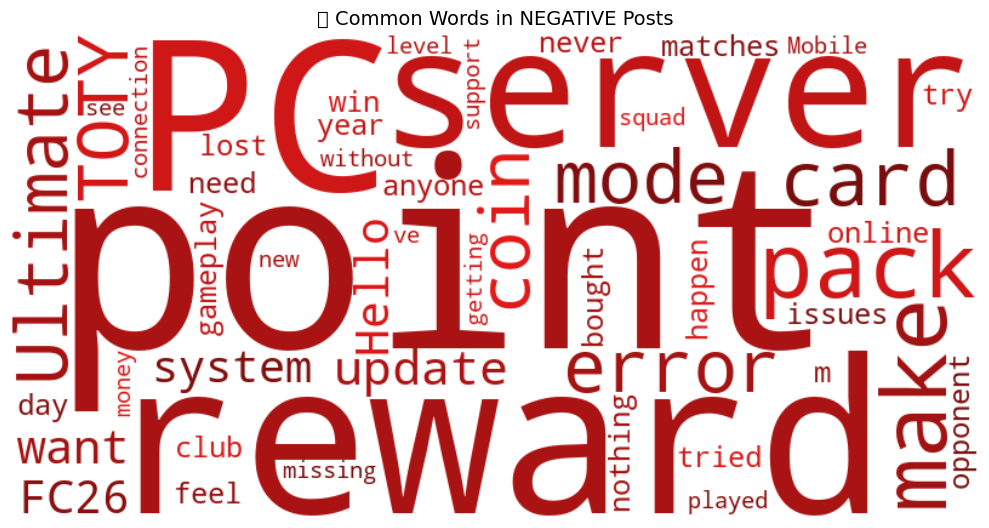

In [4]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

custom_stopwords = STOPWORDS.union({
    'ea', 'game', 'games', 'player', 'players', 'team', 'account',
    'will', 'get', 'got', 'one', 'also', 'would', 'could', 'even',
    'like', 'just', 'now', 'know', 'dont', "don't", 'im', "i'm",
    'issue', 'play', 'fc', 'problem', 'bug', 'match', 'playing', 'time', 's', 'fix', 'still', 'every', 'back', 'Please', 'Thank', 'help'
})

# Custom color function that only uses darker reds
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Generate shades from medium red to dark red (avoiding light colors)
    return f"hsl(0, 80%, {np.random.randint(25, 50)}%)"  # Lightness between 25-50%

plt.figure(figsize=(10, 6))

negative_text = ' '.join(df[df['sentiment'] == 'Negative']['full_text'].dropna())
wc_neg = WordCloud(width=800, height=400, background_color='white',
                  stopwords=custom_stopwords,
                  max_words=50,
                  color_func=red_color_func).generate(negative_text)
plt.imshow(wc_neg, interpolation='bilinear')
plt.title('🔴 Common Words in NEGATIVE Posts', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

Available columns: ['title', 'author', 'category', 'timestamp', 'sentiment', 'confidence', 'compound_score', 'views', 'likes', 'comments', 'body_preview']


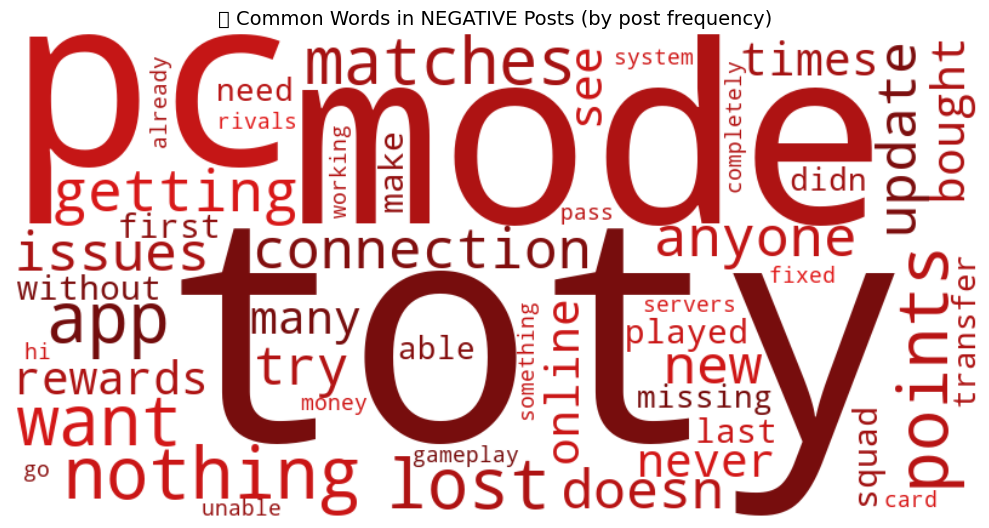


Top 20 words by number of posts containing them:
----------------------------------------
toty                   144 posts
mode                   138 posts
pc                     129 posts
nothing                104 posts
points                  98 posts
lost                    97 posts
want                    97 posts
app                     96 posts
matches                 96 posts
getting                 94 posts
connection              92 posts
anyone                  92 posts
doesn                   89 posts
new                     89 posts
update                  89 posts
issues                  89 posts
try                     87 posts
rewards                 87 posts
online                  85 posts
many                    84 posts


In [7]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import re

# Load your data
df = pd.read_csv("ea_forum_sentiment_roberta.csv")

# Check what columns exist
print("Available columns:", df.columns.tolist())

custom_stopwords = STOPWORDS.union({
    'ea', 'game', 'games', 'player', 'players', 'team', 'account', 'tried','error', 
    'will', 'get', 'got', 'one', 'also', 'would', 'could', 'even', 'hello', 'don',
    'like', 'just', 'now', 'know', 'dont', "don't", 'im', "i'm", 'ultimate',
    'issue', 'play', 'fc', 'problem', 'bug', 'match', 'playing', 'time', 
    's', 'fix', 'still', 'every', 'back', 'please', 'thank', 'help',
    't', 'u', 've', 're', 'll', 'd', 'm'  # Common contractions
})

def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl(0, 80%, {np.random.randint(25, 50)}%)"

def count_words_by_post_frequency(texts, stopwords):
    """
    Count how many POSTS contain each word (not total occurrences).
    Each word is counted at most ONCE per post.
    """
    word_post_counts = Counter()
    
    for text in texts:
        if pd.isna(text):
            continue
        # Tokenize: lowercase and extract words
        words = re.findall(r'\b[a-zA-Z]{2,}\b', text.lower())
        # Get unique words in this post (each word counted once per post)
        unique_words = set(words)
        # Remove stopwords
        unique_words = {w for w in unique_words if w not in stopwords}
        # Update counts
        word_post_counts.update(unique_words)
    
    return dict(word_post_counts)

# Filter negative posts
negative_df = df[df['sentiment'] == 'Negative'].copy()

# Combine title and body_preview to create full_text
# (Use the same columns your original word cloud used)
negative_df['full_text'] = (
    negative_df['title'].fillna('') + ' ' + negative_df['body_preview'].fillna('')
)
negative_texts = negative_df['full_text']

# Count words by POST FREQUENCY (not total occurrences)
word_frequencies = count_words_by_post_frequency(negative_texts, custom_stopwords)

# Generate word cloud from frequencies
plt.figure(figsize=(10, 6))
wc_neg = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    max_words=50,
    color_func=red_color_func
).generate_from_frequencies(word_frequencies)  # <-- KEY CHANGE

plt.imshow(wc_neg, interpolation='bilinear')
plt.title('🔴 Common Words in NEGATIVE Posts (by post frequency)', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

# Print top 20 words to verify
print("\nTop 20 words by number of posts containing them:")
print("-" * 40)
for word, count in sorted(word_frequencies.items(), key=lambda x: -x[1])[:20]:
    print(f"{word:20s} {count:5d} posts")

In [5]:
import pandas as pd

def analyze_top_posts(csv_path: str = "ea_forum_sentiment_roberta.csv"):
    """Analyze and display top positive and negative posts by comments and views."""
    
    # Load the data
    df = pd.read_csv(csv_path)
    
    # Display settings for pandas
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.width', None)
    
    # Parse timestamps and show date range
    # Note: Timestamps are timezone-naive (no TZ offset in source data, e.g. "2026-01-21T09:30:00")
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    min_date = df['timestamp'].min()
    max_date = df['timestamp'].max()
    
    print("=" * 100)
    print("DATA RANGE")
    print("=" * 100)
    print(f"Earliest post: {min_date.strftime('%Y-%m-%d %H:%M:%S')} (timezone unknown)")
    print(f"Latest post:   {max_date.strftime('%Y-%m-%d %H:%M:%S')} (timezone unknown)")
    print(f"Total posts:   {len(df):,}")
    print()
    
    # Filter negative posts (sentiment == 'Negative')
    negative_df = df[df['sentiment'] == 'Negative'].copy()
    
    # Keywords to search for
    #keywords = ["reward", "PC", "server", "Ultimate", "toty", "card", "coin", "points", "pack"]
    keywords = ["toty"]
    
    # Count negative posts for each keyword
    keyword_counts = []
    for keyword in keywords:
        mask = (
            negative_df['title'].str.contains(keyword, case=False, na=False) |
            negative_df['body_preview'].str.contains(keyword, case=False, na=False)
        )
        count = mask.sum()
        keyword_counts.append((keyword, count))
    
    # Sort keywords by count in descending order (most negative posts first)
    keyword_counts.sort(key=lambda x: x[1], reverse=True)
    
    # Print results in sorted order
    for keyword, _ in keyword_counts:
        print_keyword_results(negative_df, keyword)


def print_keyword_results(negative_df: pd.DataFrame, keyword: str):
    """Print top 3 negative posts containing a specific keyword."""
    
    # Case-insensitive search in title and body_preview
    mask = (
        negative_df['title'].str.contains(keyword, case=False, na=False) |
        negative_df['body_preview'].str.contains(keyword, case=False, na=False)
    )
    
    filtered_df = negative_df[mask].copy()
    filtered_df = filtered_df.sort_values(by='comments', ascending=False)
    top_results = filtered_df.head(30)
    
    print("=" * 100)
    print(f"TOP 3 NEGATIVE POSTS CONTAINING \"{keyword}\" (by comments)")
    print(f"Found {len(filtered_df):,} negative posts containing \"{keyword}\"")
    print("=" * 100)
    
    if len(top_results) == 0:
        print("\nNo posts found matching this criteria.\n")
        return
    
    for idx, (_, row) in enumerate(top_results.iterrows(), 1):
        print(f"\n{'─' * 80}")
        print(f"#{idx}")
        print(f"Title:       {row['title']}")
        print(f"Author:      {row['author']}")
        print(f"Category:    {row['category']}")
        print(f"Timestamp:   {row['timestamp'].strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Score:       {row['compound_score']:.4f}")
        print(f"Confidence:  {row['confidence']:.4f}")
        print(f"Views:       {row['views']:,}")
        print(f"Likes:       {row['likes']:,}")
        print(f"Comments:    {row['comments']:,}")
        print(f"Body:")
        print(f"  {row['body_preview']}")
    
    print("\n\n")


if __name__ == "__main__":
    analyze_top_posts()

DATA RANGE
Earliest post: 2026-01-14 09:45:00 (timezone unknown)
Latest post:   2026-01-21 09:30:00 (timezone unknown)
Total posts:   1,551

TOP 3 NEGATIVE POSTS CONTAINING "toty" (by comments)
Found 151 negative posts containing "toty"

────────────────────────────────────────────────────────────────────────────────
#1
Title:       No xp pro clubs fc26
Author:      ammer9
Category:    FC 26 Bug Reports
Timestamp:   2026-01-21 09:05:00
Score:       -0.7186
Confidence:  0.7186
Views:       412
Likes:       26
Comments:    45
Body:
  I have played more than 10 matches in pro clubs but I am not receiving any XP after completing the games. 
 
 ⚡Highlighted CM response: 
 Hello everyone, 
 Thank you for bringing up this XP issue in Clubs with the TOTY edition. 
 We've passed on the issue to the team so they can investigate.

────────────────────────────────────────────────────────────────────────────────
#2
Title:       Concerns regarding the new TOTY event..
Author:      5qmwwfmsuvsu
Categ

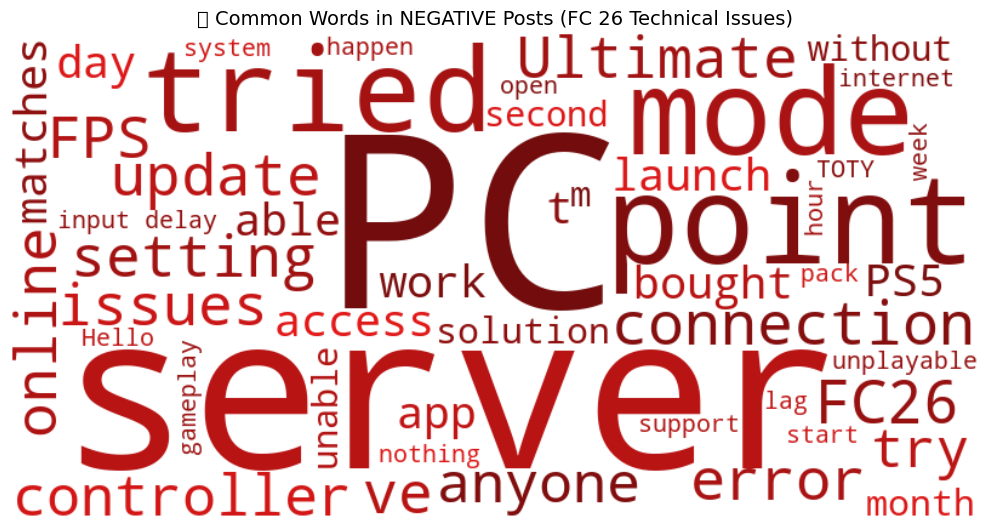

In [6]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

custom_stopwords = STOPWORDS.union({
    'ea', 'game', 'games', 'player', 'players', 'team', 'account',
    'will', 'get', 'got', 'one', 'also', 'would', 'could', 'even',
    'like', 'just', 'now', 'know', 'dont', "don't", 'im', "i'm",
    'issue', 'play', 'fc', 'problem', 'bug', 'match', 'playing', 'time', 's', 'fix', 'still', 'every', 'back', 'Please', 'Thank', 'help'
})

# Custom color function that only uses darker reds
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Generate shades from medium red to dark red (avoiding light colors)
    return f"hsl(0, 80%, {np.random.randint(25, 50)}%)"  # Lightness between 25-50%

plt.figure(figsize=(10, 6))

# Filter for FC 26 Technical Issues category AND Negative sentiment
technical_issues_df = df[df['category'] == 'FC 26 Technical Issues']
negative_technical_df = technical_issues_df[technical_issues_df['sentiment'] == 'Negative']

negative_text = ' '.join(negative_technical_df['full_text'].dropna())

wc_neg = WordCloud(width=800, height=400, background_color='white',
                  stopwords=custom_stopwords,
                  max_words=50,
                  color_func=red_color_func).generate(negative_text)
plt.imshow(wc_neg, interpolation='bilinear')
plt.title('🔴 Common Words in NEGATIVE Posts (FC 26 Technical Issues)', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


Available columns: ['title', 'author', 'category', 'timestamp', 'sentiment', 'confidence', 'compound_score', 'views', 'likes', 'comments', 'body_preview']

Total FC 26 Technical Issues posts: 404
Negative FC 26 Technical Issues posts: 345


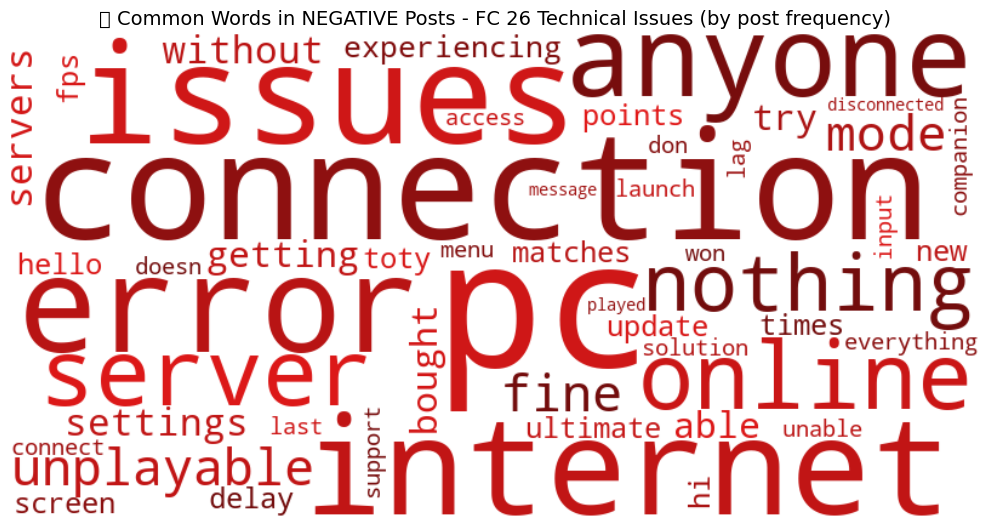


Top 20 words by number of posts containing them (FC 26 Technical Issues - Negative):
------------------------------------------------------------
pc                      76 posts ( 22.0%)
connection              50 posts ( 14.5%)
issues                  43 posts ( 12.5%)
internet                42 posts ( 12.2%)
error                   41 posts ( 11.9%)
anyone                  40 posts ( 11.6%)
online                  38 posts ( 11.0%)
server                  38 posts ( 11.0%)
nothing                 37 posts ( 10.7%)
unplayable              37 posts ( 10.7%)
fine                    37 posts ( 10.7%)
mode                    36 posts ( 10.4%)
settings                36 posts ( 10.4%)
servers                 35 posts ( 10.1%)
without                 34 posts (  9.9%)
getting                 34 posts (  9.9%)
able                    34 posts (  9.9%)
try                     34 posts (  9.9%)
bought                  33 posts (  9.6%)
experiencing            33 posts (  9.6%)


In [14]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import re

# Load your data
df = pd.read_csv("ea_forum_sentiment_roberta.csv")

# Check what columns exist
print("Available columns:", df.columns.tolist())

custom_stopwords = STOPWORDS.union({
    'ea', 'game', 'games', 'player', 'players', 'team', 'account',
    'will', 'get', 'got', 'one', 'also', 'would', 'could', 'even',
    'like', 'just', 'now', 'know', 'dont', "don't", 'im', "i'm", "app",
    'issue', 'play', 'fc', 'problem', 'bug', 'match', 'playing', 'time', 
    's', 'fix', 'still', 'every', 'back', 'please', 'thank', 'help', 'tried',
    't', 'u', 've', 're', 'll', 'd', 'm'  # Common contractions
})

def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl(0, 80%, {np.random.randint(25, 50)}%)"

def count_words_by_post_frequency(texts, stopwords):
    """
    Count how many POSTS contain each word (not total occurrences).
    Each word is counted at most ONCE per post.
    """
    word_post_counts = Counter()
    
    for text in texts:
        if pd.isna(text):
            continue
        # Tokenize: lowercase and extract words
        words = re.findall(r'\b[a-zA-Z]{2,}\b', text.lower())
        # Get unique words in this post (each word counted once per post)
        unique_words = set(words)
        # Remove stopwords
        unique_words = {w for w in unique_words if w not in stopwords}
        # Update counts
        word_post_counts.update(unique_words)
    
    return dict(word_post_counts)

# Filter for FC 26 Technical Issues category AND Negative sentiment
technical_issues_df = df[df['category'] == 'FC 26 Technical Issues']
negative_technical_df = technical_issues_df[technical_issues_df['sentiment'] == 'Negative'].copy()

print(f"\nTotal FC 26 Technical Issues posts: {len(technical_issues_df)}")
print(f"Negative FC 26 Technical Issues posts: {len(negative_technical_df)}")

# Combine title and body_preview to create full_text
negative_technical_df['full_text'] = (
    negative_technical_df['title'].fillna('') + ' ' + negative_technical_df['body_preview'].fillna('')
)
negative_texts = negative_technical_df['full_text']

# Count words by POST FREQUENCY (not total occurrences)
word_frequencies = count_words_by_post_frequency(negative_texts, custom_stopwords)

# Generate word cloud from frequencies
plt.figure(figsize=(10, 6))
wc_neg = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    max_words=50,
    color_func=red_color_func
).generate_from_frequencies(word_frequencies)

plt.imshow(wc_neg, interpolation='bilinear')
plt.title('🔴 Common Words in NEGATIVE Posts - FC 26 Technical Issues (by post frequency)', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

# Print top 20 words to verify
print("\nTop 20 words by number of posts containing them (FC 26 Technical Issues - Negative):")
print("-" * 60)
for word, count in sorted(word_frequencies.items(), key=lambda x: -x[1])[:20]:
    pct = (count / len(negative_technical_df)) * 100
    print(f"{word:20s} {count:5d} posts ({pct:5.1f}%)")


In [15]:
import pandas as pd

def analyze_technical_issues_posts(csv_path: str = "ea_forum_sentiment_roberta.csv"):
    """Analyze and display top negative posts in FC 26 Technical Issues category by comments."""
    
    # Load the data
    df = pd.read_csv(csv_path)
    
    # Display settings for pandas
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.width', None)
    
    # Parse timestamps
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Filter for FC 26 Technical Issues category
    technical_issues_df = df[df['category'] == 'FC 26 Technical Issues'].copy()
    
    min_date = technical_issues_df['timestamp'].min()
    max_date = technical_issues_df['timestamp'].max()
    
    print("=" * 100)
    print("FC 26 TECHNICAL ISSUES - DATA RANGE")
    print("=" * 100)
    print(f"Earliest post: {min_date.strftime('%Y-%m-%d %H:%M:%S')} (timezone unknown)")
    print(f"Latest post:   {max_date.strftime('%Y-%m-%d %H:%M:%S')} (timezone unknown)")
    print(f"Total posts in category:   {len(technical_issues_df):,}")
    print()
    
    # Filter negative posts within Technical Issues
    negative_df = technical_issues_df[technical_issues_df['sentiment'] == 'Negative'].copy()
    print(f"Negative posts in category: {len(negative_df):,}")
    print()
    
    # Keywords relevant to technical issues
    keywords = ["pc","connection"]
    
    # Count negative posts for each keyword
    keyword_counts = []
    for keyword in keywords:
        mask = (
            negative_df['title'].str.contains(keyword, case=False, na=False) |
            negative_df['body_preview'].str.contains(keyword, case=False, na=False)
        )
        count = mask.sum()
        keyword_counts.append((keyword, count))
    
    # Sort keywords by count in descending order (most negative posts first)
    keyword_counts.sort(key=lambda x: x[1], reverse=True)
    
    # Print results in sorted order
    for keyword, count in keyword_counts:
        if count > 0:  # Only show keywords with results
            print_keyword_results(negative_df, keyword)


def print_keyword_results(negative_df: pd.DataFrame, keyword: str):
    """Print top 30 negative posts containing a specific keyword."""
    
    # Case-insensitive search in title and body_preview
    mask = (
        negative_df['title'].str.contains(keyword, case=False, na=False) |
        negative_df['body_preview'].str.contains(keyword, case=False, na=False)
    )
    
    filtered_df = negative_df[mask].copy()
    filtered_df = filtered_df.sort_values(by='comments', ascending=False)
    top_results = filtered_df.head(30)
    
    print("=" * 100)
    print(f"TOP 30 NEGATIVE TECHNICAL ISSUES POSTS CONTAINING \"{keyword}\" (by comments)")
    print(f"Found {len(filtered_df):,} negative posts containing \"{keyword}\"")
    print("=" * 100)
    
    if len(top_results) == 0:
        print("\nNo posts found matching this criteria.\n")
        return
    
    for idx, (_, row) in enumerate(top_results.iterrows(), 1):
        print(f"\n{'─' * 80}")
        print(f"#{idx}")
        print(f"Title:       {row['title']}")
        print(f"Author:      {row['author']}")
        print(f"Category:    {row['category']}")
        print(f"Timestamp:   {row['timestamp'].strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Score:       {row['compound_score']:.4f}")
        print(f"Confidence:  {row['confidence']:.4f}")
        print(f"Views:       {row['views']:,}")
        print(f"Likes:       {row['likes']:,}")
        print(f"Comments:    {row['comments']:,}")
        print(f"Body:")
        print(f"  {row['body_preview']}")
    
    print("\n\n")


if __name__ == "__main__":
    analyze_technical_issues_posts()


FC 26 TECHNICAL ISSUES - DATA RANGE
Earliest post: 2026-01-14 09:45:00 (timezone unknown)
Latest post:   2026-01-21 09:29:00 (timezone unknown)
Total posts in category:   404

Negative posts in category: 345

TOP 30 NEGATIVE TECHNICAL ISSUES POSTS CONTAINING "pc" (by comments)
Found 76 negative posts containing "pc"

────────────────────────────────────────────────────────────────────────────────
#1
Title:       PC Controller NOT WORKING online - Why it fails and how to temporarily solve it
Author:      AdriBeh
Category:    FC 26 Technical Issues
Timestamp:   2026-01-18 11:54:00
Score:       -0.7237
Confidence:  0.7237
Views:       94,000
Likes:       188
Comments:    1,238
Body:
  If you are facing problems with PC controllers and your controller does this:   Works perfectly in offline: moments, squad battles, ...  At online matches: rivals, tournaments works for a few seconds and suddenly stops working, you can only pass or shoot   Then you have the same problem as me.  Apparently it

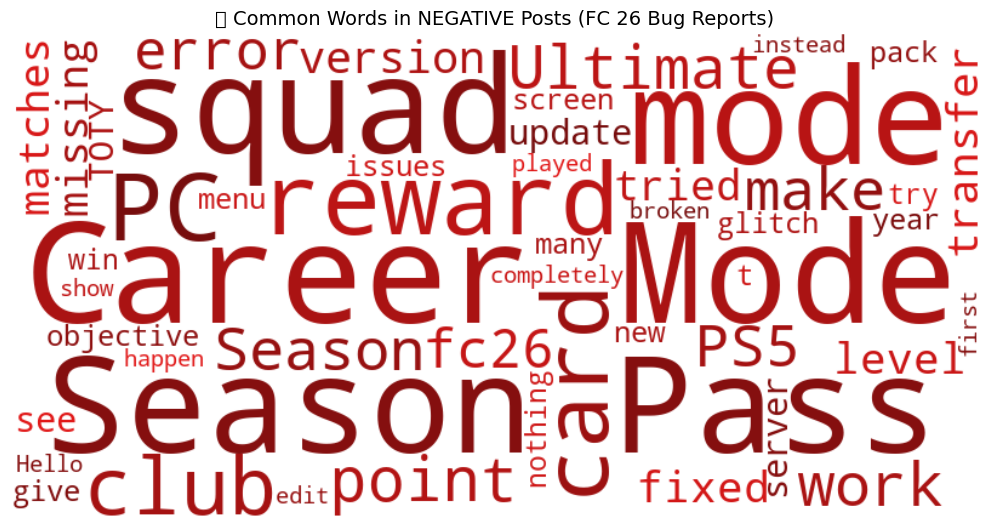

In [7]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

custom_stopwords = STOPWORDS.union({
    'ea', 'game', 'games', 'player', 'players', 'team', 'account',
    'will', 'get', 'got', 'one', 'also', 'would', 'could', 'even',
    'like', 'just', 'now', 'know', 'dont', "don't", 'im', "i'm",
    'issue', 'play', 'fc', 'problem', 'bug', 'match', 'playing', 'time', 's', 'fix', 'still', 'every', 'back', 'Please', 'Thank', 'help'
})

# Custom color function that only uses darker reds
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Generate shades from medium red to dark red (avoiding light colors)
    return f"hsl(0, 80%, {np.random.randint(25, 50)}%)"  # Lightness between 25-50%

plt.figure(figsize=(10, 6))

# Filter for FC 26 Technical Issues category AND Negative sentiment
technical_issues_df = df[df['category'] == 'FC 26 Bug Reports']
negative_technical_df = technical_issues_df[technical_issues_df['sentiment'] == 'Negative']

negative_text = ' '.join(negative_technical_df['full_text'].dropna())

wc_neg = WordCloud(width=800, height=400, background_color='white',
                  stopwords=custom_stopwords,
                  max_words=50,
                  color_func=red_color_func).generate(negative_text)
plt.imshow(wc_neg, interpolation='bilinear')
plt.title('🔴 Common Words in NEGATIVE Posts (FC 26 Bug Reports)', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


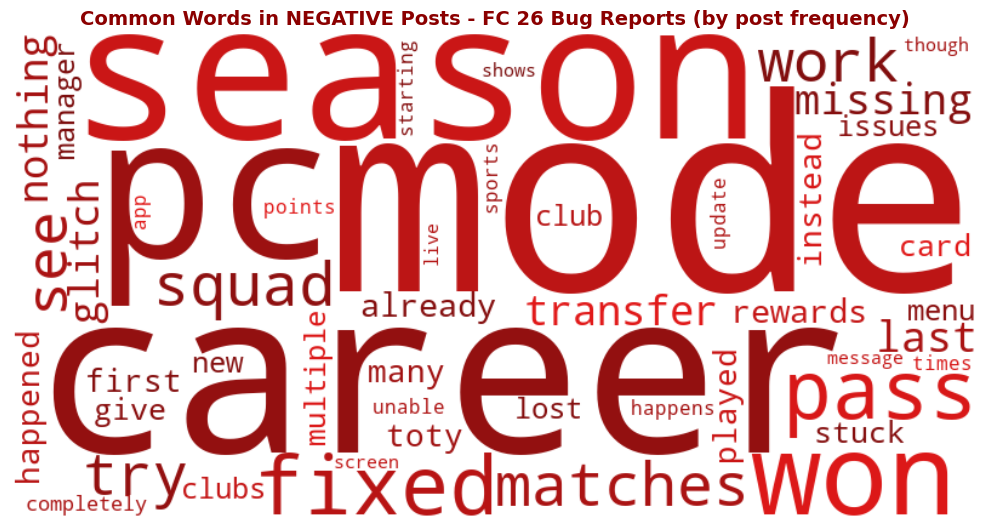


Total negative posts in FC 26 Bug Reports: 228

Top 20 words by number of posts containing them:
---------------------------------------------
mode                    52 posts ( 22.8%)
career                  36 posts ( 15.8%)
pc                      27 posts ( 11.8%)
season                  27 posts ( 11.8%)
won                     24 posts ( 10.5%)
fixed                   24 posts ( 10.5%)
pass                    24 posts ( 10.5%)
matches                 23 posts ( 10.1%)
squad                   23 posts ( 10.1%)
work                    22 posts (  9.6%)
try                     21 posts (  9.2%)
see                     21 posts (  9.2%)
missing                 20 posts (  8.8%)
last                    20 posts (  8.8%)
nothing                 19 posts (  8.3%)
transfer                19 posts (  8.3%)
glitch                  19 posts (  8.3%)
already                 19 posts (  8.3%)
rewards                 19 posts (  8.3%)
played                  18 posts (  7.9%)


In [2]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import re

# Load your data (adjust path if needed)
df = pd.read_csv("ea_forum_sentiment_roberta.csv")

custom_stopwords = STOPWORDS.union({
    'ea', 'game', 'games', 'player', 'players', 'team', 'account', 'tried', 'error', 'removed',
    'will', 'get', 'got', 'one', 'also', 'would', 'could', 'even', 'hello', 'don', 'didn',
    'like', 'just', 'now', 'know', 'dont', "don't", 'im', "i'm", 'ultimate', 'want',
    'issue', 'play', 'fc', 'problem', 'bug', 'match', 'playing', 'time',
    's', 'fix', 'still', 'every', 'back', 'please', 'thank', 'help',
    't', 'u', 've', 're', 'll', 'd', 'm'  # Common contractions
})

def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl(0, 80%, {np.random.randint(25, 50)}%)"

def count_words_by_post_frequency(texts, stopwords):
    """
    Count how many POSTS contain each word (not total occurrences).
    Each word is counted at most ONCE per post.
    """
    word_post_counts = Counter()
    
    for text in texts:
        if pd.isna(text):
            continue
        # Tokenize: lowercase and extract words
        words = re.findall(r'\b[a-zA-Z]{2,}\b', text.lower())
        # Get unique words in this post (each word counted once per post)
        unique_words = set(words)
        # Remove stopwords
        unique_words = {w for w in unique_words if w not in stopwords}
        # Update counts
        word_post_counts.update(unique_words)
    
    return dict(word_post_counts)

# Filter for FC 26 Bug Reports category AND Negative sentiment
technical_issues_df = df[df['category'] == 'FC 26 Bug Reports']
negative_technical_df = technical_issues_df[technical_issues_df['sentiment'] == 'Negative'].copy()

# Create full_text if it doesn't exist (combine title and body_preview)
if 'full_text' not in negative_technical_df.columns:
    negative_technical_df['full_text'] = (
        negative_technical_df['title'].fillna('') + ' ' + 
        negative_technical_df['body_preview'].fillna('')
    )

negative_texts = negative_technical_df['full_text']

# Count words by POST FREQUENCY (not total occurrences)
word_frequencies = count_words_by_post_frequency(negative_texts, custom_stopwords)

# Generate word cloud from frequencies
plt.figure(figsize=(10, 6))
wc_neg = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=50,
    color_func=red_color_func
).generate_from_frequencies(word_frequencies)

plt.imshow(wc_neg, interpolation='bilinear')
plt.title('Common Words in NEGATIVE Posts - FC 26 Bug Reports (by post frequency)', 
          fontsize=14, color='darkred', fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

# Print top 20 words to verify
print(f"\nTotal negative posts in FC 26 Bug Reports: {len(negative_technical_df)}")
print("\nTop 20 words by number of posts containing them:")
print("-" * 45)
for word, count in sorted(word_frequencies.items(), key=lambda x: -x[1])[:20]:
    pct = (count / len(negative_technical_df)) * 100
    print(f"{word:20s} {count:5d} posts ({pct:5.1f}%)")


In [19]:
import pandas as pd

def analyze_fc26_bug_reports(csv_path: str = "ea_forum_sentiment_roberta.csv"):
    """Analyze and display top negative posts in FC 26 Bug Reports category by comments."""
    
    # Load the data
    df = pd.read_csv(csv_path)
    
    # Display settings for pandas
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.width', None)
    
    # Parse timestamps
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Filter for FC 26 Bug Reports category
    fc26_bugs_df = df[df['category'] == 'FC 26 Bug Reports'].copy()
    
    min_date = fc26_bugs_df['timestamp'].min()
    max_date = fc26_bugs_df['timestamp'].max()
    
    print("=" * 100)
    print("FC 26 BUG REPORTS - DATA RANGE")
    print("=" * 100)
    print(f"Earliest post: {min_date.strftime('%Y-%m-%d %H:%M:%S')} (timezone unknown)")
    print(f"Latest post:   {max_date.strftime('%Y-%m-%d %H:%M:%S')} (timezone unknown)")
    print(f"Total posts in category:   {len(fc26_bugs_df):,}")
    print()
    
    # Filter negative posts within FC 26 Bug Reports
    negative_df = fc26_bugs_df[fc26_bugs_df['sentiment'] == 'Negative'].copy()
    print(f"Negative posts in category: {len(negative_df):,}")
    print()
    
    # Keywords relevant to FC 26 bug reports (console/PC game)
    keywords = ["season","mode","career"]
    
    # Count negative posts for each keyword
    keyword_counts = []
    for keyword in keywords:
        mask = (
            negative_df['title'].str.contains(keyword, case=False, na=False) |
            negative_df['body_preview'].str.contains(keyword, case=False, na=False)
        )
        count = mask.sum()
        keyword_counts.append((keyword, count))
    
    # Sort keywords by count in descending order (most negative posts first)
    keyword_counts.sort(key=lambda x: x[1], reverse=True)
    
    # Print results in sorted order
    for keyword, count in keyword_counts:
        if count > 0:  # Only show keywords with results
            print_keyword_results(negative_df, keyword)


def print_keyword_results(negative_df: pd.DataFrame, keyword: str):
    """Print top 5 negative posts containing a specific keyword."""
    
    # Case-insensitive search in title and body_preview
    mask = (
        negative_df['title'].str.contains(keyword, case=False, na=False) |
        negative_df['body_preview'].str.contains(keyword, case=False, na=False)
    )
    
    filtered_df = negative_df[mask].copy()
    filtered_df = filtered_df.sort_values(by='comments', ascending=False)
    top_results = filtered_df.head(15)
    
    print("=" * 100)
    print(f"TOP 15 NEGATIVE FC 26 BUG REPORTS CONTAINING \"{keyword}\" (by comments)")
    print(f"Found {len(filtered_df):,} negative posts containing \"{keyword}\"")
    print("=" * 100)
    
    if len(top_results) == 0:
        print("\nNo posts found matching this criteria.\n")
        return
    
    for idx, (_, row) in enumerate(top_results.iterrows(), 1):
        print(f"\n{'─' * 80}")
        print(f"#{idx}")
        print(f"Title:       {row['title']}")
        print(f"Author:      {row['author']}")
        print(f"Category:    {row['category']}")
        print(f"Timestamp:   {row['timestamp'].strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Score:       {row['compound_score']:.4f}")
        print(f"Confidence:  {row['confidence']:.4f}")
        print(f"Views:       {row['views']:,}")
        print(f"Likes:       {row['likes']:,}")
        print(f"Comments:    {row['comments']:,}")
        print(f"Body:")
        print(f"  {row['body_preview']}")
    
    print("\n\n")


if __name__ == "__main__":
    analyze_fc26_bug_reports()


FC 26 BUG REPORTS - DATA RANGE
Earliest post: 2026-01-14 10:55:00 (timezone unknown)
Latest post:   2026-01-21 09:05:00 (timezone unknown)
Total posts in category:   291

Negative posts in category: 228

TOP 15 NEGATIVE FC 26 BUG REPORTS CONTAINING "mode" (by comments)
Found 62 negative posts containing "mode"

────────────────────────────────────────────────────────────────────────────────
#1
Title:       Edit Teams and Kick Off mode are broken functions of EA FC26
Author:      Dubziie_0
Category:    FC 26 Bug Reports
Timestamp:   2026-01-21 04:02:00
Score:       -0.5825
Confidence:  0.5825
Views:       1,500
Likes:       10
Comments:    386
Body:
  We play locally and edit teams to make custom squads. We have done this for years on FIFA and there was never an issue until FC25 where the game crashed after you edited teams and tried to play  The issue was fixed FC25 in January. To our disbelief the issue is back in FC26.  Please see 8 others posts complaining about the same issue:  EA 

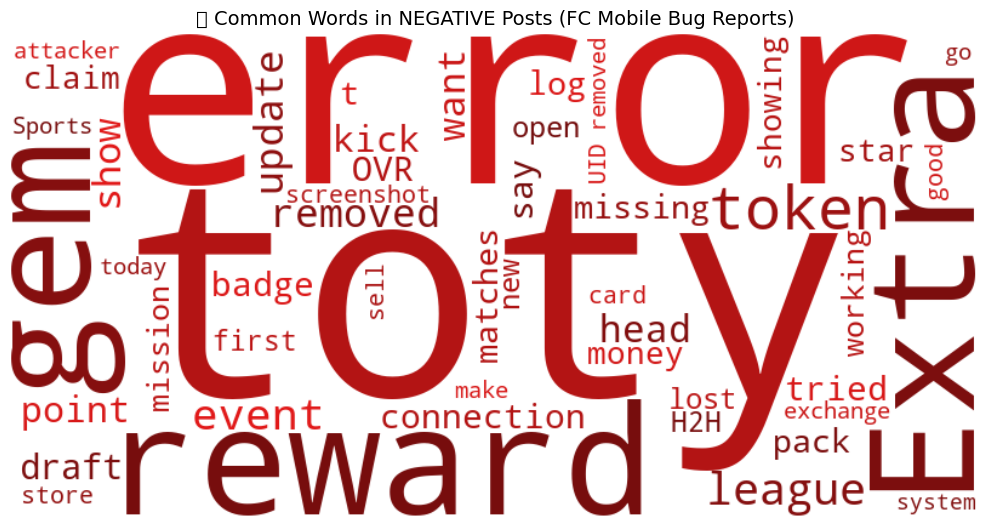

In [8]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

custom_stopwords = STOPWORDS.union({
    'ea', 'game', 'games', 'player', 'players', 'team', 'account',
    'will', 'get', 'got', 'one', 'also', 'would', 'could', 'even',
    'like', 'just', 'now', 'know', 'dont', "don't", 'im', "i'm",
    'issue', 'play', 'fc', 'problem', 'bug', 'match', 'playing', 'time', 's', 'fix', 'still', 'every', 'back', 'Please', 'Thank', 'help', 'mobile', 'Hello'
})

# Custom color function that only uses darker reds
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Generate shades from medium red to dark red (avoiding light colors)
    return f"hsl(0, 80%, {np.random.randint(25, 50)}%)"  # Lightness between 25-50%

plt.figure(figsize=(10, 6))

# Filter for FC 26 Technical Issues category AND Negative sentiment
technical_issues_df = df[df['category'] == 'FC Mobile Bug Reports']
negative_technical_df = technical_issues_df[technical_issues_df['sentiment'] == 'Negative']

negative_text = ' '.join(negative_technical_df['full_text'].dropna())

wc_neg = WordCloud(width=800, height=400, background_color='white',
                  stopwords=custom_stopwords,
                  max_words=50,
                  color_func=red_color_func).generate(negative_text)
plt.imshow(wc_neg, interpolation='bilinear')
plt.title('🔴 Common Words in NEGATIVE Posts (FC Mobile Bug Reports)', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


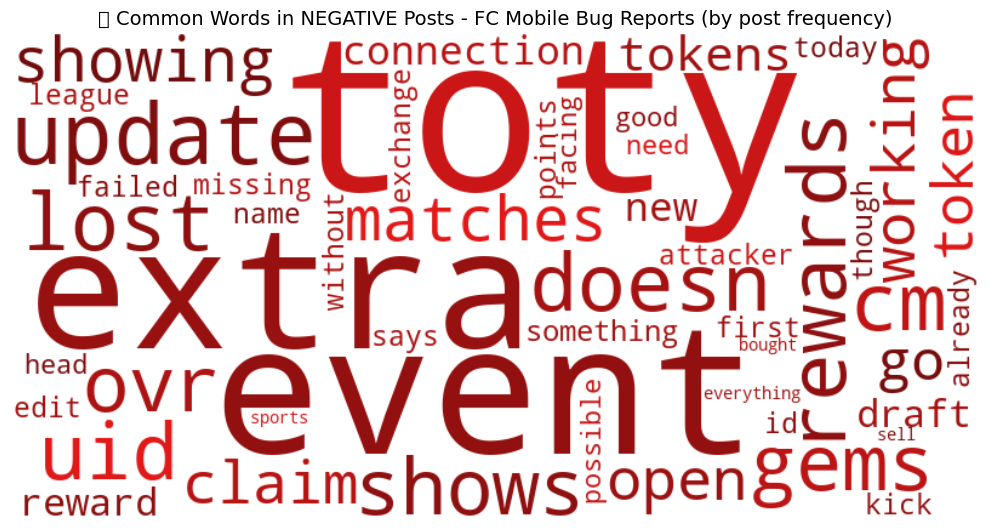


Total negative posts in FC Mobile Bug Reports: 200

Top 20 words by number of posts containing them:
---------------------------------------------
toty                    35 posts ( 17.5%)
event                   23 posts ( 11.5%)
extra                   20 posts ( 10.0%)
update                  17 posts (  8.5%)
cm                      15 posts (  7.5%)
rewards                 15 posts (  7.5%)
lost                    15 posts (  7.5%)
doesn                   15 posts (  7.5%)
uid                     14 posts (  7.0%)
ovr                     14 posts (  7.0%)
gems                    14 posts (  7.0%)
shows                   14 posts (  7.0%)
showing                 14 posts (  7.0%)
matches                 14 posts (  7.0%)
claim                   13 posts (  6.5%)
working                 13 posts (  6.5%)
open                    13 posts (  6.5%)
token                   12 posts (  6.0%)
go                      12 posts (  6.0%)
tokens                  12 posts (  6.0%)


In [27]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import re

# Load your data (adjust path if needed)
df = pd.read_csv("ea_forum_sentiment_roberta.csv")

custom_stopwords = STOPWORDS.union({
    'ea', 'game', 'games', 'player', 'players', 'team', 'account', 'tried', 'error', 'removed',
    'will', 'get', 'got', 'one', 'also', 'would', 'could', 'even', 'hello', 'don', 'didn',
    'like', 'just', 'now', 'know', 'dont', "don't", 'im', "i'm", 'ultimate', 'want',
    'issue', 'play', 'fc', 'problem', 'bug', 'match', 'playing', 'time',
    's', 'fix', 'still', 'every', 'back', 'please', 'thank', 'help', 'mobile',
    't', 'u', 've', 're', 'll', 'd', 'm'  # Common contractions
})

def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return f"hsl(0, 80%, {np.random.randint(25, 50)}%)"

def count_words_by_post_frequency(texts, stopwords):
    """
    Count how many POSTS contain each word (not total occurrences).
    Each word is counted at most ONCE per post.
    """
    word_post_counts = Counter()
    
    for text in texts:
        if pd.isna(text):
            continue
        # Tokenize: lowercase and extract words
        words = re.findall(r'\b[a-zA-Z]{2,}\b', text.lower())
        # Get unique words in this post (each word counted once per post)
        unique_words = set(words)
        # Remove stopwords
        unique_words = {w for w in unique_words if w not in stopwords}
        # Update counts
        word_post_counts.update(unique_words)
    
    return dict(word_post_counts)

# Filter for FC Mobile Bug Reports category AND Negative sentiment
technical_issues_df = df[df['category'] == 'FC Mobile Bug Reports']
negative_technical_df = technical_issues_df[technical_issues_df['sentiment'] == 'Negative'].copy()

# Create full_text if it doesn't exist (combine title and body_preview)
if 'full_text' not in negative_technical_df.columns:
    negative_technical_df['full_text'] = (
        negative_technical_df['title'].fillna('') + ' ' + 
        negative_technical_df['body_preview'].fillna('')
    )

negative_texts = negative_technical_df['full_text']

# Count words by POST FREQUENCY (not total occurrences)
word_frequencies = count_words_by_post_frequency(negative_texts, custom_stopwords)

# Generate word cloud from frequencies
plt.figure(figsize=(10, 6))
wc_neg = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=50,
    color_func=red_color_func
).generate_from_frequencies(word_frequencies)

plt.imshow(wc_neg, interpolation='bilinear')
plt.title('🔴 Common Words in NEGATIVE Posts - FC Mobile Bug Reports (by post frequency)', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

# Print top 20 words to verify
print(f"\nTotal negative posts in FC Mobile Bug Reports: {len(negative_technical_df)}")
print("\nTop 20 words by number of posts containing them:")
print("-" * 45)
for word, count in sorted(word_frequencies.items(), key=lambda x: -x[1])[:20]:
    pct = (count / len(negative_technical_df)) * 100
    print(f"{word:20s} {count:5d} posts ({pct:5.1f}%)")


In [27]:
import pandas as pd

def analyze_mobile_bug_reports(csv_path: str = "ea_forum_sentiment_roberta.csv"):
    """Analyze and display top negative posts in FC Mobile Bug Reports category by comments."""
    
    # Load the data
    df = pd.read_csv(csv_path)
    
    # Display settings for pandas
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.width', None)
    
    # Parse timestamps
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Filter for FC Mobile Bug Reports category
    mobile_bugs_df = df[df['category'] == 'FC Mobile Bug Reports'].copy()
    
    min_date = mobile_bugs_df['timestamp'].min()
    max_date = mobile_bugs_df['timestamp'].max()
    
    print("=" * 100)
    print("FC MOBILE BUG REPORTS - DATA RANGE")
    print("=" * 100)
    print(f"Earliest post: {min_date.strftime('%Y-%m-%d %H:%M:%S')} (timezone unknown)")
    print(f"Latest post:   {max_date.strftime('%Y-%m-%d %H:%M:%S')} (timezone unknown)")
    print(f"Total posts in category:   {len(mobile_bugs_df):,}")
    print()
    
    # Filter negative posts within Mobile Bug Reports
    negative_df = mobile_bugs_df[mobile_bugs_df['sentiment'] == 'Negative'].copy()
    print(f"Negative posts in category: {len(negative_df):,}")
    print()
    
    # Keywords relevant to mobile bug reports
    keywords = ["toty", "event", "extra"]

    
    # Count negative posts for each keyword
    keyword_counts = []
    for keyword in keywords:
        mask = (
            negative_df['title'].str.contains(keyword, case=False, na=False) |
            negative_df['body_preview'].str.contains(keyword, case=False, na=False)
        )
        count = mask.sum()
        keyword_counts.append((keyword, count))
    
    # Sort keywords by count in descending order (most negative posts first)
    keyword_counts.sort(key=lambda x: x[1], reverse=True)
    
    # Print results in sorted order
    for keyword, count in keyword_counts:
        if count > 0:  # Only show keywords with results
            print_keyword_results(negative_df, keyword)


def print_keyword_results(negative_df: pd.DataFrame, keyword: str):
    """Print top 3 negative posts containing a specific keyword."""
    
    # Case-insensitive search in title and body_preview
    mask = (
        negative_df['title'].str.contains(keyword, case=False, na=False) |
        negative_df['body_preview'].str.contains(keyword, case=False, na=False)
    )
    
    filtered_df = negative_df[mask].copy()
    filtered_df = filtered_df.sort_values(by='comments', ascending=False)
    top_results = filtered_df.head(30)
    
    print("=" * 100)
    print(f"TOP 3 NEGATIVE FC MOBILE BUG REPORTS CONTAINING \"{keyword}\" (by comments)")
    print(f"Found {len(filtered_df):,} negative posts containing \"{keyword}\"")
    print("=" * 100)
    
    if len(top_results) == 0:
        print("\nNo posts found matching this criteria.\n")
        return
    
    for idx, (_, row) in enumerate(top_results.iterrows(), 1):
        print(f"\n{'─' * 80}")
        print(f"#{idx}")
        print(f"Title:       {row['title']}")
        print(f"Author:      {row['author']}")
        print(f"Category:    {row['category']}")
        print(f"Timestamp:   {row['timestamp'].strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Score:       {row['compound_score']:.4f}")
        print(f"Confidence:  {row['confidence']:.4f}")
        print(f"Views:       {row['views']:,}")
        print(f"Likes:       {row['likes']:,}")
        print(f"Comments:    {row['comments']:,}")
        print(f"Body:")
        print(f"  {row['body_preview']}")
    
    print("\n\n")


if __name__ == "__main__":
    analyze_mobile_bug_reports()


FC MOBILE BUG REPORTS - DATA RANGE
Earliest post: 2026-01-14 11:42:00 (timezone unknown)
Latest post:   2026-01-21 09:29:00 (timezone unknown)
Total posts in category:   257

Negative posts in category: 200

TOP 3 NEGATIVE FC MOBILE BUG REPORTS CONTAINING "toty" (by comments)
Found 40 negative posts containing "toty"

────────────────────────────────────────────────────────────────────────────────
#1
Title:       Cannot claim milestone UTOTY Attacker rewards
Author:      motadanso
Category:    FC Mobile Bug Reports
Timestamp:   2026-01-21 00:51:00
Score:       -0.6052
Confidence:  0.6052
Views:       153
Likes:       1
Comments:    30
Body:
  I already have 23 UTOTY players but I cannot claim rewards that requires the 15 and 20 UTOTY players.

────────────────────────────────────────────────────────────────────────────────
#2
Title:       Bug Report: Kick Off Missions Missing from Activity Tab
Author:      vz84ewtj2brv
Category:    FC Mobile Bug Reports
Timestamp:   2026-01-21 04:17:00